# QCNN性能测试3

Training QCNN with data for randomly picked data for 0.2 ≤ Γ ≤ 1.8

In [1]:
import mindspore as ms
from mindspore.dataset import NumpySlicesDataset
from mindspore.train.callback import LossMonitor, Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from mindspore.common.tensor import Tensor
from mindspore._checkparam import Validator
from src.dataset import build_dataset
from src.qcnn import QCNNet
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

In [2]:
class MyLossMonitor(Callback):
    def __init__(self, per_print_times=1):
        super(MyLossMonitor, self).__init__()
        Validator.check_non_negative_int(per_print_times)
        self._per_print_times = per_print_times
        self._last_print_time = 0
        self.ls = []

    def step_end(self, run_context):
        """
        Print training loss at the end of step.

        Args:
            run_context (RunContext): Include some information of the model.
        """
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], Tensor) and isinstance(loss[0].asnumpy(), np.ndarray):
                loss = loss[0]
        if isinstance(loss, Tensor) and isinstance(loss.asnumpy(), np.ndarray):
            loss = float(np.mean(loss.asnumpy()))
        self.ls.append(loss)
        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        if isinstance(loss, float) and (np.isnan(loss) or np.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format(
                cb_params.cur_epoch_num, cur_step_in_epoch))

        #In disaster recovery scenario, the cb_params.cur_step_num may be rollback to previous step
        # and be less than self._last_print_time, so self._last_print_time need to be updated.
        if self._per_print_times != 0 and (cb_params.cur_step_num <= self._last_print_time):
            while cb_params.cur_step_num <= self._last_print_time:
                self._last_print_time -=\
                    max(self._per_print_times, cb_params.batch_num if cb_params.dataset_sink_mode else 1)

        if self._per_print_times != 0 and (cb_params.cur_step_num - self._last_print_time) >= self._per_print_times:
            self._last_print_time = cb_params.cur_step_num
            print("epoch: %s step: %s, loss is %s" % (cb_params.cur_epoch_num, cur_step_in_epoch, loss), flush=True)

class StepAcc(Callback):
    def __init__(self, model, test_x, test_y):
        self.model = model
        self.test_x = test_x
        self.test_y = test_y.flatten()
        self.acc = []

    def step_end(self, run_context):
        pred_y = self.model.predict(self.test_x)
        self.acc.append((self.test_y == pred_y).mean())

### epoch=30, seed=1202

In [3]:
epoch = 30
seed = 1202
path = './TFI_chain/closed/'

### N=4, batch=12

In [5]:
N = 4
dbatch = 10
encoder, encoder_params_name, x, y = build_dataset(N, path, 1)
print(f'N = {N}')
print(f'epoch = {epoch}')
print(f'seed = {seed}')
ms.set_seed(seed)
model = QCNNet(N, encoder)
y = y.reshape((y.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)
train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(X_train.shape[0] // dbatch)
monitor = MyLossMonitor(11)
acc = StepAcc(model, X_test, y_test)
callbacks=[monitor, acc]
model.train(epoch, train_loader, callbacks)
print('finished')

N = 4
epoch = 30
seed = 1202
epoch: 1 step: 11, loss is 0.6238941550254822
epoch: 2 step: 11, loss is 0.6335462331771851
epoch: 3 step: 11, loss is 0.6099722981452942
epoch: 4 step: 11, loss is 0.6049693822860718
epoch: 5 step: 11, loss is 0.6013189554214478
epoch: 6 step: 11, loss is 0.6044074296951294
epoch: 7 step: 11, loss is 0.5989964008331299
epoch: 8 step: 11, loss is 0.5971895456314087
epoch: 9 step: 11, loss is 0.6005688905715942
epoch: 10 step: 11, loss is 0.6010136604309082
epoch: 11 step: 11, loss is 0.5982344150543213
epoch: 12 step: 11, loss is 0.5985764265060425
epoch: 13 step: 11, loss is 0.5992714166641235
epoch: 14 step: 11, loss is 0.5988163948059082
epoch: 15 step: 11, loss is 0.598720908164978
epoch: 16 step: 11, loss is 0.5986085534095764
epoch: 17 step: 11, loss is 0.5978878736495972
epoch: 18 step: 11, loss is 0.5974013805389404
epoch: 19 step: 11, loss is 0.5974092483520508
epoch: 20 step: 11, loss is 0.5974333882331848
epoch: 21 step: 11, loss is 0.59741187095

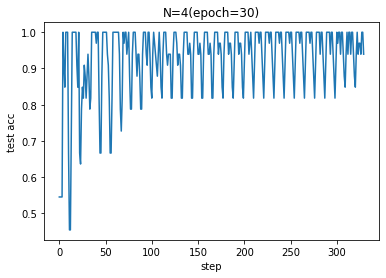

In [8]:
# 测试集acc变化曲线
plt.plot(range(len(acc.acc)), acc.acc)
plt.xlabel('step')
plt.ylabel('test acc')
plt.title('N=4(epoch=30)')
plt.show()

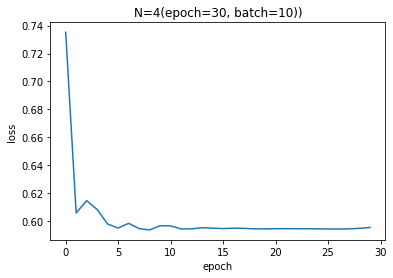

In [9]:
# 损失值变化曲线
loss = list()
ls = monitor.ls
for i in range(30):
    loss.append(ls[i*11])
plt.plot(range(30), loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'N={N}(epoch=30, batch=10))')
plt.show()

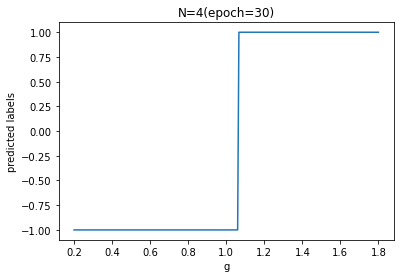

In [6]:
# 预测结果
encoder, encoder_params_name, x, y = build_dataset(N, path, 2)
pred_y = model.predict(x)
plt.plot(np.linspace(0.2,1.8,pred_y.shape[0]), pred_y)
plt.title('N=4(epoch=30)')
plt.ylabel('predicted labels')
plt.xlabel('g')
plt.show()

In [10]:
# 精度
encoder, encoder_params_name, x, y = build_dataset(N, path)
x = x[y!=0]
y = y[y!=0]
pred_y = model.predict(x)
acc = np.mean(y.flatten() == pred_y.flatten())
print(f"Acc: {acc}")

Acc: 0.9625


### N=4, batch=128

In [11]:
N = 4
encoder, encoder_params_name, x, y = build_dataset(N, path, 1)
print(f'N = {N}')
print(f'epoch = {epoch}')
print(f'seed = {seed}')
ms.set_seed(seed)
model = QCNNet(N, encoder)
y = y.reshape((y.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)
train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(X_train.shape[0])
monitor = MyLossMonitor(5)
acc = StepAcc(model, X_test, y_test)
callbacks=[monitor, acc]
model.train(epoch, train_loader, callbacks)
print('finished')

N = 4
epoch = 30
seed = 1202
epoch: 5 step: 1, loss is 0.6336211562156677
epoch: 10 step: 1, loss is 0.6102410554885864
epoch: 15 step: 1, loss is 0.6083407402038574
epoch: 20 step: 1, loss is 0.6045833826065063
epoch: 25 step: 1, loss is 0.6022962331771851
epoch: 30 step: 1, loss is 0.6002990007400513
finished


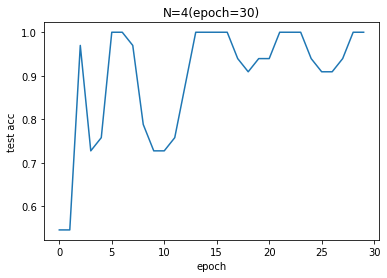

In [12]:
# 测试集acc变化曲线
plt.plot(range(len(acc.acc)), acc.acc)
plt.xlabel('epoch')
plt.ylabel('test acc')
plt.title('N=4(epoch=30)')
plt.show()

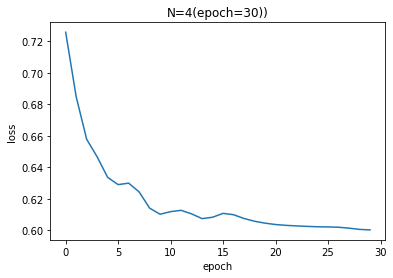

In [13]:
# 损失值变化曲线
plt.plot(range(len(monitor.ls)), monitor.ls)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('N=4(epoch=30))')
plt.show()

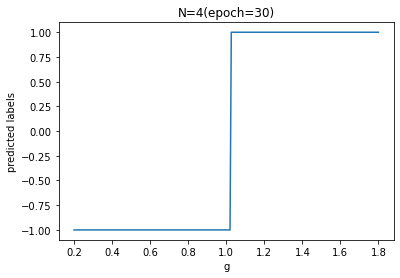

In [14]:
# 预测结果
encoder, encoder_params_name, x, y = build_dataset(N, path, 2)
pred_y = model.predict(x)
plt.plot(np.linspace(0.2,1.8,pred_y.shape[0]), pred_y)
plt.title('N=4(epoch=30)')
plt.ylabel('predicted labels')
plt.xlabel('g')
plt.show()

In [15]:
# 精度
encoder, encoder_params_name, x, y = build_dataset(N, path)
x = x[y!=0]
y = y[y!=0]
pred_y = model.predict(x)
acc = np.mean(y.flatten() == pred_y.flatten())
print(f"Acc: {acc}")

Acc: 0.9875


### N=8, batch=128

In [8]:
N = 8
encoder, encoder_params_name, x, y = build_dataset(N, path, 1)
print(f'N = {N}')
print(f'epoch = {epoch}')
print(f'seed = {seed}')
ms.set_seed(seed)
model = QCNNet(N, encoder)
y = y.reshape((y.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)
train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(X_train.shape[0])
monitor = MyLossMonitor(5)
acc = StepAcc(model, X_test, y_test)
callbacks=[monitor, acc]
model.train(epoch, train_loader, callbacks)
print('finished')

N = 8
epoch = 30
seed = 1202
epoch: 5 step: 1, loss is 0.5930218696594238
epoch: 10 step: 1, loss is 0.5773119926452637
epoch: 15 step: 1, loss is 0.5647391080856323
epoch: 20 step: 1, loss is 0.5606873631477356
epoch: 25 step: 1, loss is 0.5535140633583069
epoch: 30 step: 1, loss is 0.5501086115837097
finished


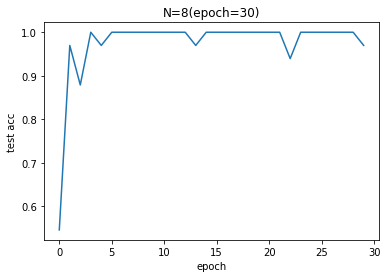

In [9]:
# 测试集acc变化曲线
plt.plot(range(len(acc.acc)), acc.acc)
plt.xlabel('epoch')
plt.ylabel('test acc')
plt.title(f'N={N}(epoch=30)')
plt.show()

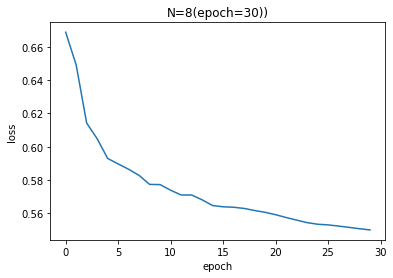

In [10]:
# 损失值变化曲线
plt.plot(range(len(monitor.ls)), monitor.ls)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'N={N}(epoch=30))')
plt.show()

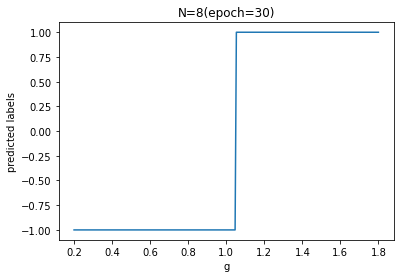

In [11]:
# 预测结果
encoder, encoder_params_name, x, y = build_dataset(N, path, 2)
pred_y = model.predict(x)
plt.plot(np.linspace(0.2,1.8,pred_y.shape[0]), pred_y)
plt.title(f'N={N}(epoch=30)')
plt.ylabel('predicted labels')
plt.xlabel('g')
plt.show()

In [12]:
# 精度
encoder, encoder_params_name, x, y = build_dataset(N, path)
x = x[y!=0]
y = y[y!=0]
pred_y = model.predict(x)
acc = np.mean(y.flatten() == pred_y.flatten())
print(f"Acc: {acc}")

Acc: 0.975


### N=12, batch=12

In [18]:
N = 12
dbatch = 10
encoder, encoder_params_name, x, y = build_dataset(N, path, 1)
print(f'N = {N}')
print(f'epoch = {epoch}')
print(f'seed = {seed}')
ms.set_seed(seed)
model = QCNNet(N, encoder)
y = y.reshape((y.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)
train_loader = NumpySlicesDataset({'features': X_train, 'labels': y_train}, shuffle=False).batch(X_train.shape[0] // dbatch)
monitor = MyLossMonitor(5)
acc = StepAcc(model, X_test, y_test)
callbacks=[monitor, acc]
model.train(epoch, train_loader, callbacks)
print('finished')

N = 12
epoch = 30
seed = 1202
epoch: 1 step: 5, loss is 0.6495696902275085
epoch: 1 step: 10, loss is 0.6402842998504639
epoch: 2 step: 4, loss is 0.6013408303260803
epoch: 2 step: 9, loss is 0.5980995297431946
epoch: 3 step: 3, loss is 0.6029548048973083
epoch: 3 step: 8, loss is 0.5668076276779175
epoch: 4 step: 2, loss is 0.6063290238380432
epoch: 4 step: 7, loss is 0.5680229067802429
epoch: 5 step: 1, loss is 0.5557498335838318
epoch: 5 step: 6, loss is 0.5676904320716858
epoch: 5 step: 11, loss is 0.5580657720565796
epoch: 6 step: 5, loss is 0.5637860894203186
epoch: 6 step: 10, loss is 0.5629523992538452
epoch: 7 step: 4, loss is 0.5409809350967407
epoch: 7 step: 9, loss is 0.5456149578094482
epoch: 8 step: 3, loss is 0.5590271353721619
epoch: 8 step: 8, loss is 0.49869099259376526
epoch: 9 step: 2, loss is 0.5367773175239563
epoch: 9 step: 7, loss is 0.49811577796936035
epoch: 10 step: 1, loss is 0.4982835352420807
epoch: 10 step: 6, loss is 0.5132450461387634
epoch: 10 step: 11

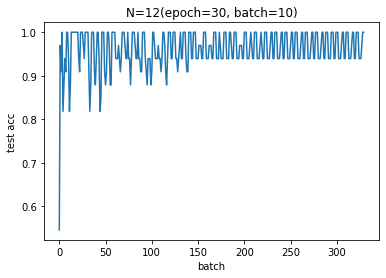

In [20]:
# 测试集acc变化曲线
plt.plot(range(len(acc.acc)), acc.acc)
plt.xlabel('batch')
plt.ylabel('test acc')
plt.title(f'N={N}(epoch=30, batch=10)')
plt.show()

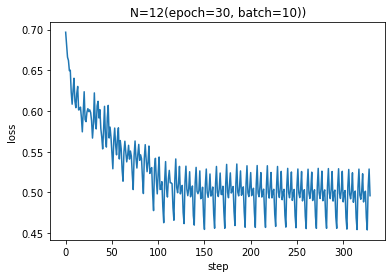

In [25]:
# 损失值变化曲线
plt.plot(range(len(monitor.ls)), monitor.ls)
plt.xlabel('step')
plt.ylabel('loss')
plt.title(f'N={N}(epoch=30, batch=10))')
plt.show()

In [26]:
print(len(monitor.ls))
print(X_train.shape)

330
(128, 12)


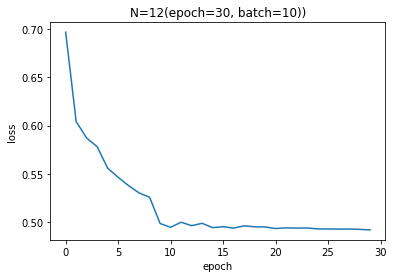

In [28]:
# 损失值变化曲线
loss = list()
ls = monitor.ls
for i in range(30):
    loss.append(ls[i*11])
plt.plot(range(30), loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'N={N}(epoch=30, batch=10))')
plt.show()

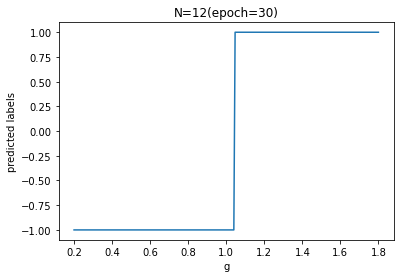

In [22]:
# 预测结果
encoder, encoder_params_name, x, y = build_dataset(N, path, 2)
pred_y = model.predict(x)
plt.plot(np.linspace(0.2,1.8,pred_y.shape[0]), pred_y)
plt.title(f'N={N}(epoch=30)')
plt.ylabel('predicted labels')
plt.xlabel('g')
plt.show()

In [23]:
# 精度
encoder, encoder_params_name, x, y = build_dataset(N, path)
x = x[y!=0]
y = y[y!=0]
pred_y = model.predict(x)
acc = np.mean(y.flatten() == pred_y.flatten())
print(f"Acc: {acc}")

Acc: 0.975
